In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
# Import the data
in_dir = 'data/'
in_file = 'ex6_ImagData2Load.mat'
data = sio.loadmat(in_dir + in_file)
ImgT1 = data['ImgT1']
ImgT2 = data['ImgT2']
ROI_GM = data['ROI_GM'].astype(bool)
ROI_WM = data['ROI_WM'].astype(bool)

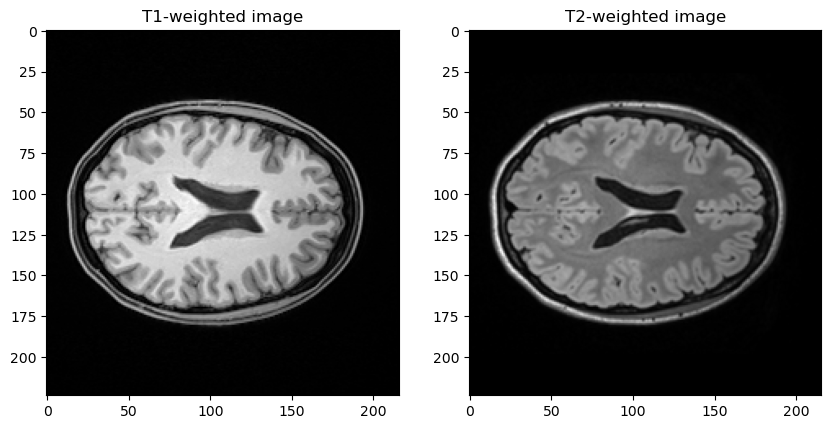

In [3]:
# Plot the images in a subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ImgT1, cmap='gray')
ax[0].set_title('T1-weighted image')
ax[1].imshow(ImgT2, cmap='gray')
ax[1].set_title('T2-weighted image')
plt.show()

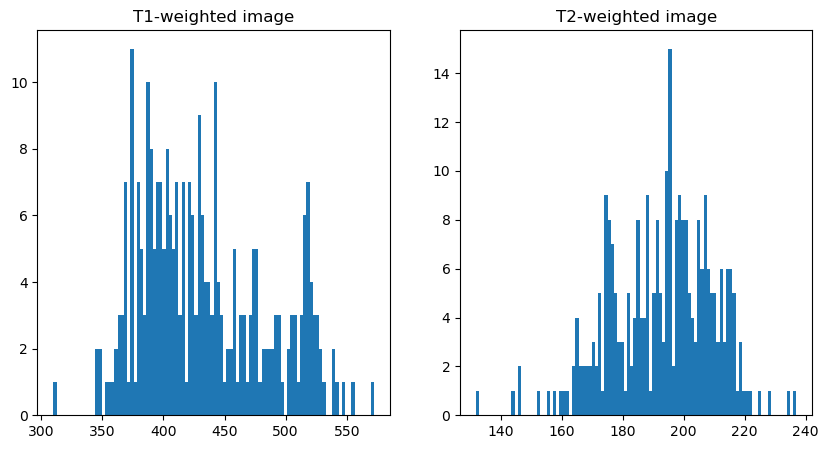

In [8]:
# Plot the histograms
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(ImgT1[ROI_GM], bins=100)
ax[0].set_title('T1-weighted image')
ax[1].hist(ImgT2[ROI_GM], bins=100)
ax[1].set_title('T2-weighted image')
plt.show()

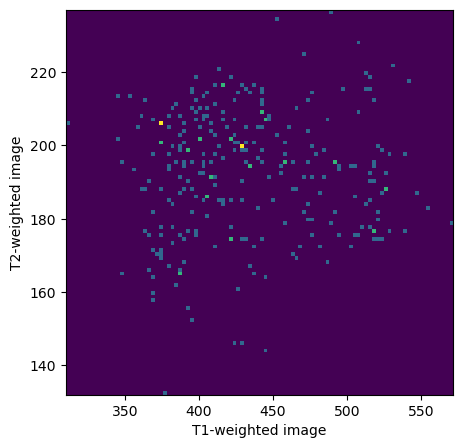

In [5]:
# Plot 2d histogram
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist2d(ImgT1[ROI_GM], ImgT2[ROI_GM], bins=100)
ax.set_xlabel('T1-weighted image')
ax.set_ylabel('T2-weighted image')
plt.show()

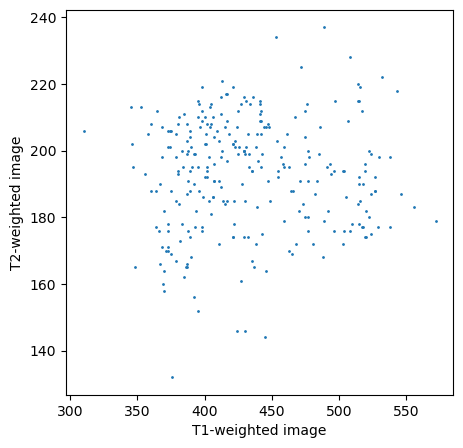

In [6]:
# Plot the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(ImgT1[ROI_GM], ImgT2[ROI_GM], s=1)
ax.set_xlabel('T1-weighted image')
ax.set_ylabel('T2-weighted image')
plt.show()

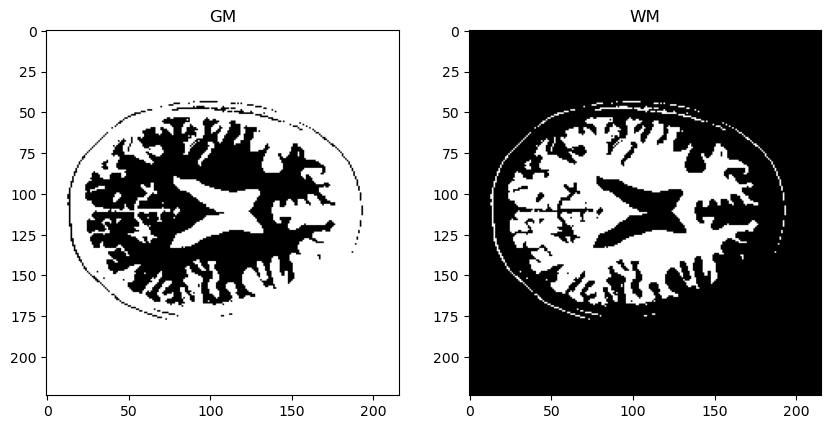

In [10]:
# Threshold to separate GM and WM
threshold = 450
GM = ImgT1 <= threshold
WM = ImgT1 > threshold

# Plot the images in a subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(GM, cmap='gray')
ax[0].set_title('GM')
ax[1].imshow(WM, cmap='gray')
ax[1].set_title('WM')
plt.show()

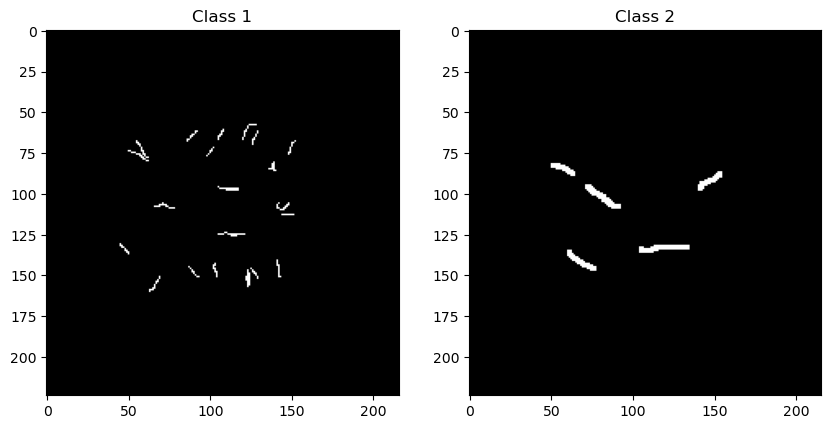

In [11]:
# Create variables C1 and C2
C1 = ImgT1[ROI_GM]
C2 = ImgT1[ROI_WM]

# Plot the images in a subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ROI_GM, cmap='gray')
ax[0].set_title('Class 1')
ax[1].imshow(ROI_WM, cmap='gray')
ax[1].set_title('Class 2')
plt.show()

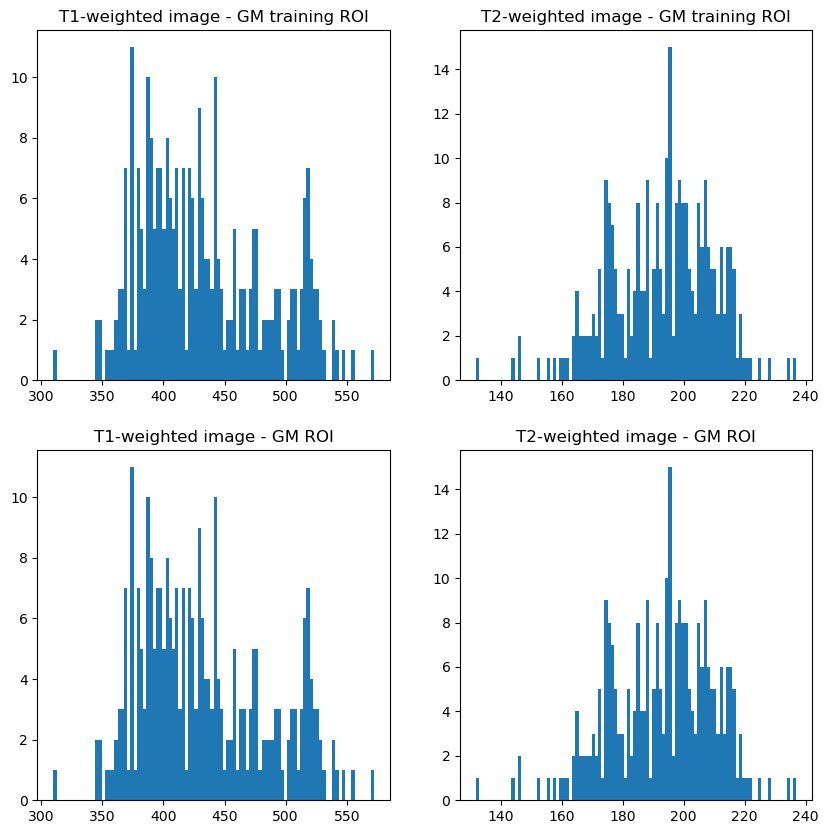

In [14]:
# Create empty lists to store the training examples
train_T1 = []
train_T2 = []

# Loop through each binary training ROI
for ROI in [ROI_GM, ROI_WM]:
    # Get the indices of the True values in the ROI
    indices = np.where(ROI)
    # Extract the corresponding values from ImgT1 and ImgT2
    T1_values = ImgT1[indices]
    T2_values = ImgT2[indices]
    # Append the values to the training lists
    train_T1.append(T1_values)
    train_T2.append(T2_values)

# Plot the 1D histograms of the training examples and 1D histograms of the whole images
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].hist(train_T1[0], bins=100)
ax[0, 0].set_title('T1-weighted image - GM training ROI')
ax[0, 1].hist(train_T2[0], bins=100)
ax[0, 1].set_title('T2-weighted image - GM training ROI')
ax[1, 0].hist(ImgT1[ROI_GM], bins=100)
ax[1, 0].set_title('T1-weighted image - GM ROI')
ax[1, 1].hist(ImgT2[ROI_GM], bins=100)
ax[1, 1].set_title('T2-weighted image - GM ROI')
plt.show()

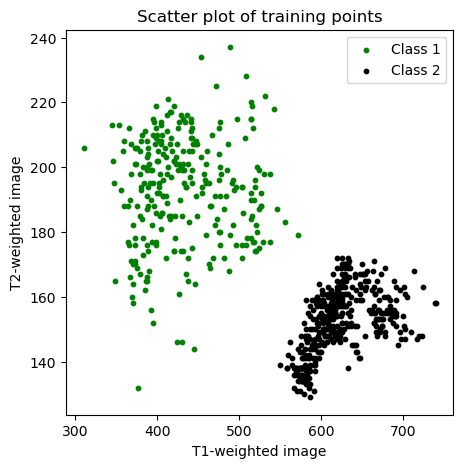

In [73]:
# Plot the scatter plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(train_T1[0], train_T2[0], s=10, c='g', label='Class 1')
ax.scatter(train_T1[1], train_T2[1], s=10, c='k', label='Class 2')
ax.set_xlabel('T1-weighted image')
ax.set_ylabel('T2-weighted image')
ax.set_title('Scatter plot of training points')
ax.legend()
plt.show()


In [74]:
import numpy as np

def LDA(X, y):
    """
    Linear Discriminant Analysis.

    A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
    Assumes equal priors among classes

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Training data
    y : array-like of shape (n_samples,)
        Target values.

    Returns
    -------
    W : array-like of shape (n_classes, n_features+1)
        Weights for making the projection. First column is the constants.

    Last modified: 11/11/22, mcbo@dtu.dk
    """
    
    # Determine size of input data
    n, m = X.shape
    # Discover and count unique class labels
    class_label = np.unique(y)
    k = len(class_label)

    # Initialize
    n_group     = np.zeros((k,1))     # Group counts
    group_mean  = np.zeros((k,m))     # Group sample means
    pooled_cov  = np.zeros((m,m))     # Pooled covariance
    W          = np.zeros((k,m+1))    # Model coefficients

    for i in range(k):
        # Establish location and size of each class
        group      = np.squeeze(y == class_label[i])
        n_group[i]  = np.sum(group.astype(np.double))
        
        # Calculate group mean vectors
        group_mean[i,:] = np.mean(X[group,:], axis = 0)
        
        # Accumulate pooled covariance information
        pooled_cov = pooled_cov + ((n_group[i] - 1) / (n - k) ) * np.cov(X[group,:], rowvar = False)
    
    # Assign prior probabilities
    prior_prob = n_group / n

    # Loop over classes to calculate linear discriminant coefficients
    for i in range(k):
        # Intermediate calculation for efficiency
        temp = group_mean[i,:][np.newaxis] @ np.linalg.inv(pooled_cov)
        
        # Constant
        W[i,0] = -0.5 * temp @ group_mean[i,:].T + np.log(prior_prob[i])
        
        # Linear
        W[i,1:] = temp

    return W

import numpy as np

# Stack the features horizontally for each class
class_1_data = np.column_stack((train_T1[0], train_T1[1][:280]))  # Data for class 1
class_2_data = np.column_stack((train_T2[0][:280], train_T2[1][:280]))  # Data for class 2

# Concatenate the class data vertically to create the training data vector
X = np.concatenate((class_1_data, class_2_data), axis=0)

# Create the target class vector
# The length of zeros corresponds to the number of samples in class 1
# The length of ones corresponds to the number of samples in class 2
T = np.concatenate((np.zeros(class_1_data.shape[0]), np.ones(class_2_data.shape[0])))

# Now you can run LDA with X and T
W = LDA(X, T)


In [66]:
# Stack the flattened T1 and T2 images horizontally to create the feature matrix Xall
Xall= np.c_[ImgT1.ravel(), ImgT2.ravel()]

# Add a column of ones to Xall to account for the bias term in the linear model
Xall = np.c_[np.ones((len(Xall), 1)), Xall]

# Compute the predicted class labels for each sample in Xall using the learned weights W
Y = Xall @ W.T


In [75]:
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y),1)[:, np.newaxis], 0, 1)

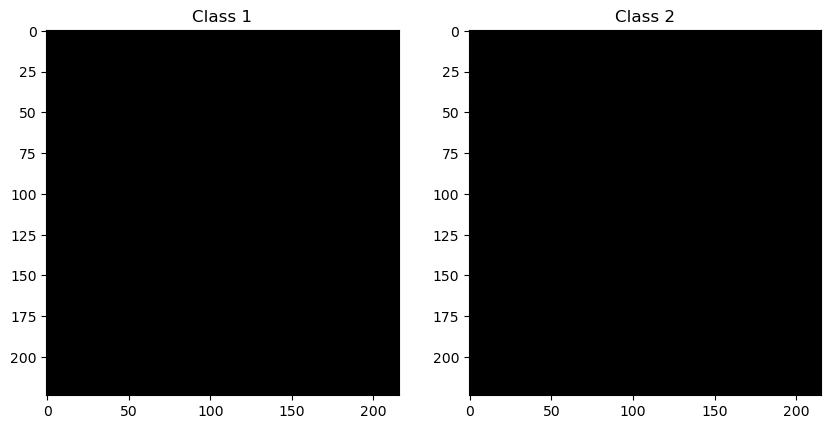

In [80]:
# Find all voxels belonging to Class 1
class_1_voxels = np.where(PosteriorProb[:, 0] > 0.5)[0]

# Find all voxels belonging to Class 2
class_2_voxels = np.where(PosteriorProb[:, 1] > 0.5)[0]

# Create empty arrays to store the segmented images
class_1_image = np.zeros(ImgT1.shape)
class_2_image = np.zeros(ImgT1.shape)

# Fill the segmented images with the corresponding class labels
class_1_image.ravel()[class_1_voxels] = 1
class_2_image.ravel()[class_2_voxels] = 1

# Plot the segmented images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(class_1_image, cmap='gray')
ax[0].set_title('Class 1')
ax[1].imshow(class_2_image, cmap='gray')
ax[1].set_title('Class 2')
plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

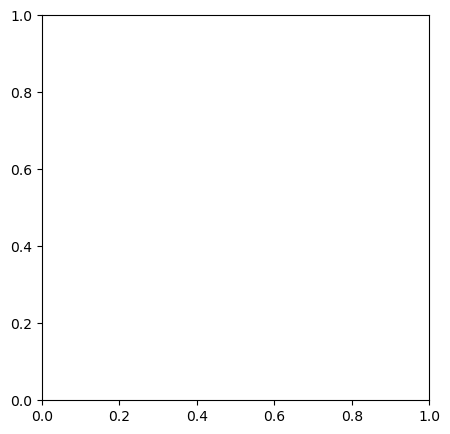

In [79]:
# Plot the scatter plot for class 1 and class 2 voxels
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(ImgT1[class_1_voxels[0]], ImgT2[class_1_voxels[0]], s=1, c='g', label='Class 1')
ax.scatter(ImgT1[class_2_voxels[0]], ImgT2[class_2_voxels[0]], s=1, c='k', label='Class 2')
ax.set_xlabel('T1-weighted image')
ax.set_ylabel('T2-weighted image')
ax.set_title('Scatter plot of segmented points')
ax.legend()
plt.show()
